# Gesture Recognition Case Study (Arjun Pujari & Sophia Shalini)


**Problem Statement**

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. 

Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |


In [1]:
## Checking the GPU configuration
!nvidia-smi

Sun Apr 10 19:17:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Importing necessary libraries
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importing libraries
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
# Check whether GPU is present or not
device = tf.test.gpu_device_name()
if "GPU" not in device:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device))

Found GPU at: /device:GPU:0


In [ ]:
# Mounting Google Drive to get the dataset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Unzipping the zip file to get the data into the environment so that we can work on it
!unzip gdrive/My\ Drive/Project_data.zip

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In [ ]:
# Removing the extra directory from the environment.
!rm -rf sample_data/

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
# Loading the training and validation doc
train_doc = np.random.permutation(open(r'/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open(r'/content/Project_data/val.csv').readlines())
batch_size = 64

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
# Cropping at center for 120*120 image
def crop_and_resize(image, y, z):
    h, w = image.shape
    if w == 160:
        image = image[:120, 20:140]
    # resize every image
    return resize(image, (y,z))

In [ ]:
# applying normalization
def normalize(image):
    return image/255.0

In [ ]:
# Function to preprocess the image using above two functions
def preprocess(image, y, z):
    return normalize(crop_and_resize(image, y, z))

In [ ]:
# Generator for getting the batch data and preprocessing the image
def getBatchData(source_path, t, batch, batch_size, img_tensor):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate preprocessImage function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = preprocess(image[:, :, 0], y, z)
            batch_data[folder,idx,:,:,1] = preprocess(image[:, :, 1], y, z)
            batch_data[folder,idx,:,:,2] = preprocess(image[:, :, 2], y, z)

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels

In [ ]:
# Generator 
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)
        
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)

In [ ]:
# Get the training and validation sequences from dataset
curr_dt_time = datetime.datetime.now()
train_path = r'/content/Project_data/train'
val_path = r'/content/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [ ]:
# Function to get the image tensor based on number of frames
def get_image_tensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 100, 100, 3]

# define image tensor size
img_tensor = get_image_tensor(20)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]


In [ ]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  /content/Project_data/train ; batch size = 64
(64, 20, 100, 100, 3)
Source path =  /content/Project_data/val ; batch size = 64
(64, 20, 100, 100, 3)


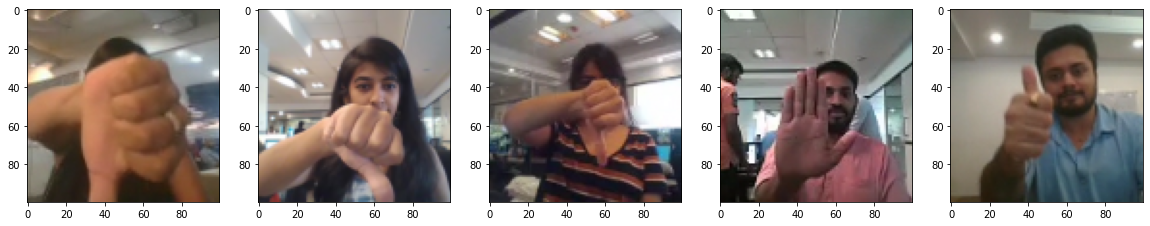

In [ ]:
# plot generated sample images
fig, ax = plt.subplots(1,5,figsize=(20, 20))
ax[0].imshow(sample_val_batch_data[10,10,:,:,:])   
ax[1].imshow(sample_val_batch_data[20,10,:,:,:])
ax[2].imshow(sample_val_batch_data[30,10,:,:,:])   
ax[3].imshow(sample_val_batch_data[40,10,:,:,:])
ax[4].imshow(sample_val_batch_data[50,10,:,:,:])   

plt.show()

In [ ]:
# Function to plot the performance of the model
def plot_performance(model):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(model.history['loss'])   
    ax[0].plot(model.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(model.history['categorical_accuracy'])   
    ax[1].plot(model.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy: ", max(model.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy: ", max(model.history['val_categorical_accuracy']))

In [ ]:
# Importing the model libraries
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers

## Model Building
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### BASE MODEL

In [ ]:
# Creating the base model
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.20))

model.add(Dense(5, activation='softmax'))

In [ ]:
# Compiling the model with Adam optimizer and getting the summary
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 100, 100, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 100, 100, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 100, 100, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 50, 50, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 50, 50, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 10, 50, 50, 32)    0

In [ ]:
# Creating a train generator and validation generator for sequences
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

In [ ]:
# Check for batch size
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Callback and Weights
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=4, min_delta=0)

callbacks_list = [LR]

We start of with choosing the appropriate batch size and number of frames we want to process.


**1. FRAMES = 16 and BATCH SIZE = 64**

In [ ]:
batch_size = 64
img_tensor = get_image_tensor(16)
print("Using frames as", img_tensor[0])
global callbacks_list
num_epochs = 3
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
# Fitting the model
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Using frames as [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]
Source path =  /content/Project_data/train ; batch size = 64
Epoch 1/3
11/11 [==============================] - 175s 16s/step - loss: 1.5859 - categorical_accuracy: 0.4238 - val_loss: 1.5902 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/3
11/11 [==============================] - 72s 7s/step - loss: 1.1339 - categorical_accuracy: 0.5731 - val_loss: 1.7649 - val_categorical_accuracy: 0.3125 - lr: 0.0010
Epoch 3/3
11/11 [==============================] - 72s 7s/step - loss: 0.9966 - categorical_accuracy: 0.6126 - val_loss: 3.4663 - val_categorical_accuracy: 0.1250 - lr: 0.0010


**2. FRAMES = 30 and BATCH SIZE = 64**

In [ ]:
# batch_size = 64
# img_tensor = get_image_tensor(30)
# print("Using frames as", img_tensor[0])
# num_epochs = 3
# train_generator = generator(train_path, train_doc, batch_size, img_tensor)
# val_generator = generator(val_path, val_doc, batch_size, img_tensor)
# if (num_train_sequences%batch_size) == 0:
#     steps_per_epoch = int(num_train_sequences/batch_size)
# else:
#     steps_per_epoch = (num_train_sequences//batch_size) + 1

# if (num_val_sequences%batch_size) == 0:
#     validation_steps = int(num_val_sequences/batch_size)
# else:
#     validation_steps = (num_val_sequences//batch_size) + 1

# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                 callbacks=callbacks_list, validation_data=val_generator, 
#                 validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

**3. FRAMES = 16 and BATCH SIZE = 32**

In [ ]:
batch_size = 32
img_tensor = get_image_tensor(16)
print("Using frames as", img_tensor[0])
global callbacks_list
num_epochs = 3
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
# Fitting the model
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Using frames as [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]
Source path =  /content/Project_data/train ; batch size = 32
Epoch 1/3
21/21 [==============================] - 161s 8s/step - loss: 0.8320 - categorical_accuracy: 0.6802 - val_loss: 4.5751 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/3
21/21 [==============================] - 112s 6s/step - loss: 0.5491 - categorical_accuracy: 0.8054 - val_loss: 4.7552 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/3
21/21 [==============================] - 92s 5s/step - loss: 0.5573 - categorical_accuracy: 0.7939 - val_loss: 7.0761 - val_categorical_accuracy: 0.3750 - lr: 0.0010


**4. FRAMES = 30 and BATCH SIZE = 32**

In [ ]:
# batch_size = 64
# img_tensor = get_image_tensor(32)
# print("Using frames as", img_tensor[0])
# global callbacks_list
# num_epochs = 3
# train_generator = generator(train_path, train_doc, batch_size, img_tensor)
# val_generator = generator(val_path, val_doc, batch_size, img_tensor)
# if (num_train_sequences%batch_size) == 0:
#     steps_per_epoch = int(num_train_sequences/batch_size)
# else:
#     steps_per_epoch = (num_train_sequences//batch_size) + 1

# if (num_val_sequences%batch_size) == 0:
#     validation_steps = int(num_val_sequences/batch_size)
# else:
#     validation_steps = (num_val_sequences//batch_size) + 1

# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                 callbacks=callbacks_list, validation_data=val_generator, 
#                 validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Based on the facts above, we may conclude that batch size has no effect on training duration but does have an effect on the amount of frames. We will choose a batch size of 64 because it appears to be the most efficient. It is commented because it takes a long time to run, making it difficult for the notebook to run entirely.

### MODEL NUMBER 1: <br>
 
**FRAMES** = 16<br>
**EPOCHS** = 20<br>
**BATCH SIZE** = 64<br>
**4** CONV3D Layers <br> **3** DENSE Layers <br>
**OPTIMIZER** = Adam<br>

In [ ]:
# Initializing the frames, epochs and batch size
n_frames = 16
num_epochs = 20
batch_size = 64

img_tensor = get_image_tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Creating the model
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.20))

model.add(Dense(5, activation='softmax'))

In [ ]:
# Compiling the model with Adam optimizer and getting the summary
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 16, 100, 100, 16)  0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 8, 50, 50, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 50, 50, 32)     13856     
                                                                 
 activation_5 (Activation)   (None, 8, 50, 50, 32)    

In [ ]:
# Fitting the model
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - 168s 17s/step - loss: 1.5412 - categorical_accuracy: 0.4133 - val_loss: 1.5696 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 78s 8s/step - loss: 1.1349 - categorical_accuracy: 0.5968 - val_loss: 1.5187 - val_categorical_accuracy: 0.2656 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 70s 7s/step - loss: 1.1643 - categorical_accuracy: 0.5613 - val_loss: 2.1251 - val_categorical_accuracy: 0.1607 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 67s 7s/step - loss: 0.9779 - categorical_accuracy: 0.5837 - val_loss: 2.0205 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 56s 6s/step - loss: 1.0192 - categorical_accuracy: 0.6220 - val_loss: 1.8817 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 

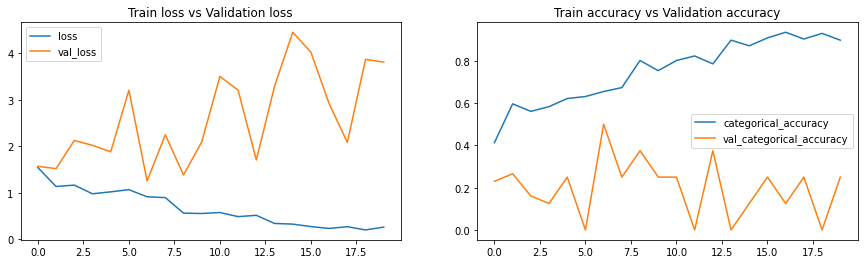

Max. Training Accuracy:  0.9358288645744324
Max. Validaiton Accuracy:  0.5


In [ ]:
plot_performance(history)

Here it is quite evident that model is overfitting. 

### MODEL NUMBER 2: <br>
 
**FRAMES** = 30<br>
**EPOCHS** = 20<br>
**BATCH SIZE** = 64<br>
**4** CONV3D Layers <br> **3** DENSE Layers <br> **L2** Regularizer at Dense Layer <br>
**OPTIMIZER** = Adam<br>

In [ ]:
# Initializing the frames, epochs and batch size
n_frames = 30
num_epochs = 20
batch_size = 64

img_tensor = get_image_tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Creating the model
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128,activation='relu', kernel_regularizer=regularizers.l2(l2=0.001)))
model.add(Dropout(0.3))

model.add(Dense(64,activation='relu', kernel_regularizer=regularizers.l2(l2=0.001)))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))

In [ ]:
# Compiling the model with Adam optimizer and getting the summary
model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 16, 100, 100, 16)  0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 8, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 8, 50, 50, 16)    64        
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 8, 50, 50, 16)     0         
                                                                 
 conv3d_9 (Conv3D)           (None, 8, 50, 50, 32)    

In [ ]:
# Fitting the model
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
11/11 [==============================] - 44s 4s/step - loss: 5.9745 - categorical_accuracy: 0.3316 - val_loss: 3722.1665 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 2/20
11/11 [==============================] - 43s 4s/step - loss: 4.6426 - categorical_accuracy: 0.3690 - val_loss: 385.3571 - val_categorical_accuracy: 0.6250 - lr: 0.0100
Epoch 3/20
11/11 [==============================] - 47s 5s/step - loss: 4.2083 - categorical_accuracy: 0.3262 - val_loss: 155.3900 - val_categorical_accuracy: 0.1250 - lr: 0.0100
Epoch 4/20
11/11 [==============================] - 41s 4s/step - loss: 4.3428 - categorical_accuracy: 0.2781 - val_loss: 10.9678 - val_categorical_accuracy: 0.1250 - lr: 0.0100
Epoch 5/20
11/11 [==============================] - 43s 4s/step - loss: 4.1343 - categorical_accuracy: 0.3209 - val_loss: 17.1250 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 6/20
11/11 [==============================] - 41s 4s/step - loss: 3.8182 - categorical_accur

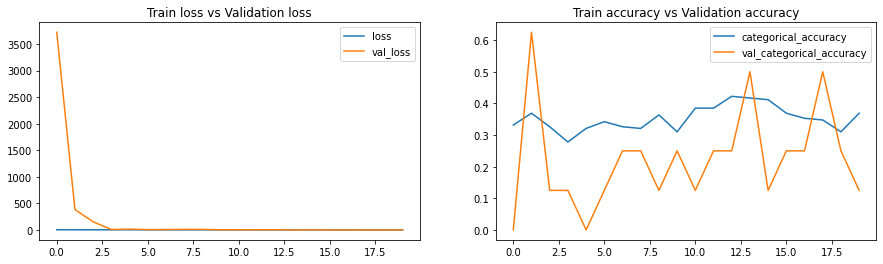

Max. Training Accuracy:  0.4224599003791809
Max. Validaiton Accuracy:  0.625


In [ ]:
plot_performance(history)

Here it is seems logical that increasing the frames increased the training time drastically but the thing to note here is that this model didn't perform well. It kept overfitting with a sizeable gap between the training accuracy and validation accuracy. 


From now on, we will only train on 16 frames as model trains faster and limited computational resource is present. 


### MODEL NUMBER 3: <br>
 
**FRAMES** = 16<br>
**EPOCHS** = 20<br>
**BATCH SIZE** = 64<br>
**4** CONV3D Layers<br>**3** DENSE Layers <br> **L2** Regularizer at Dense Layer<br>
**OPTIMIZER** = Adam<br>
**CHANGE DONE** - Reduced the Learning Rate

In [ ]:
# Initializing the frames, epochs and batch size
n_frames = 16
num_epochs = 20
batch_size = 64

img_tensor = get_image_tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Creating the model
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128,activation='relu', kernel_regularizer=regularizers.l2(l2=0.001)))
model.add(Dropout(0.3))

model.add(Dense(64,activation='relu', kernel_regularizer=regularizers.l2(l2=0.001)))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))

In [ ]:
# Compiling the model with Adam optimizer and getting the summary
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_14 (Bat  (None, 8, 50, 50, 16)    64        
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 8, 50, 50, 16)     0         
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 50, 50, 32)    

In [ ]:
# Fitting the model
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - 176s 17s/step - loss: 2.2559 - categorical_accuracy: 0.3514 - val_loss: 1.9238 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 75s 7s/step - loss: 1.8505 - categorical_accuracy: 0.4348 - val_loss: 2.0501 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 76s 8s/step - loss: 1.8693 - categorical_accuracy: 0.4664 - val_loss: 2.1993 - val_categorical_accuracy: 0.1786 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 61s 6s/step - loss: 1.9225 - categorical_accuracy: 0.4077 - val_loss: 2.1253 - val_categorical_accuracy: 0.2812 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - ETA: 0s - loss: 1.7431 - categorical_accuracy: 0.4450
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
11/11 [==============================] - 58s 6s

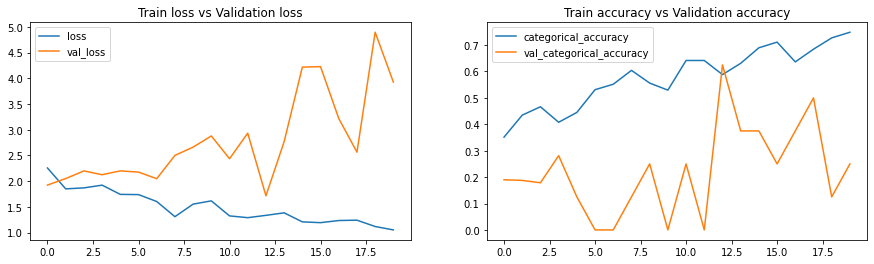

Max. Training Accuracy:  0.7486631274223328
Max. Validaiton Accuracy:  0.625


In [ ]:
plot_performance(history)

Still No Improvement

### MODEL NUMBER 4: <br>
 
**FRAMES** = 16<br>
**EPOCHS** = 20<br>
**BATCH SIZE** = 64<br>
**4** CONV3D Layers<br> **3** DENSE Layers<br> **L2** Regularizer at Dense Layer<br>
**OPTIMIZER** = Adam<br>
**CHANGE DONE** - Reduced the Learning Rate more

In [ ]:
# Initializing the frames, epochs and batch size
n_frames = 16
num_epochs = 20
batch_size = 64

img_tensor = get_image_tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Creating the model
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128,activation='relu', kernel_regularizer=regularizers.l2(l2=0.0001)))
model.add(Dropout(0.3))

model.add(Dense(64,activation='relu', kernel_regularizer=regularizers.l2(l2=0.0001)))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))

In [ ]:
# Compiling the model with Adam optimizer and getting the summary
model.compile(optimizer=RMSprop(lr=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 8, 50, 50, 16)    64        
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 8, 50, 50, 16)     0         
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 50, 50, 32)    

In [ ]:
# Fitting the model
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - 173s 17s/step - loss: 2.1979 - categorical_accuracy: 0.2278 - val_loss: 1.6428 - val_categorical_accuracy: 0.1400 - lr: 1.0000e-04
Epoch 2/20
11/11 [==============================] - 77s 8s/step - loss: 1.8067 - categorical_accuracy: 0.3439 - val_loss: 1.6742 - val_categorical_accuracy: 0.1094 - lr: 1.0000e-04
Epoch 3/20
11/11 [==============================] - 74s 7s/step - loss: 1.7607 - categorical_accuracy: 0.3320 - val_loss: 1.7296 - val_categorical_accuracy: 0.1250 - lr: 1.0000e-04
Epoch 4/20
11/11 [==============================] - 64s 6s/step - loss: 1.7114 - categorical_accuracy: 0.3004 - val_loss: 1.8612 - val_categorical_accuracy: 0.1250 - lr: 1.0000e-04
Epoch 5/20
11/11 [==============================] - 57s 6s/step - loss: 1.6099 - categorical_accuracy: 0.3684 - val_loss: 1.5677 - val_categorical_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 6/20
11/11 [==============

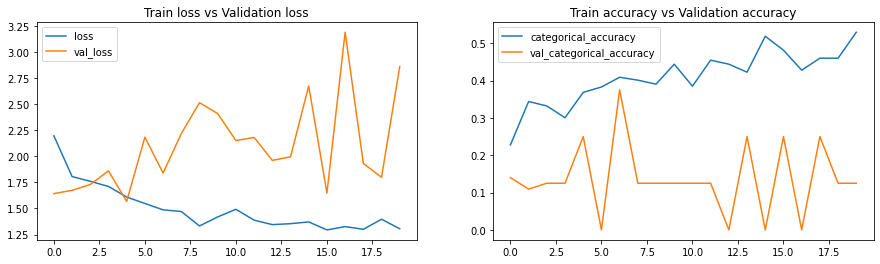

Max. Training Accuracy:  0.529411792755127
Max. Validaiton Accuracy:  0.375


In [ ]:
plot_performance(history)

We can try once by changing the optimizer and see if it works.

### MODEL NUMBER 5: <br>
 
**FRAMES** = 16<br>
**EPOCHS** = 20<br>
**BATCH SIZE** = 64<br>
**4** CONV3D Layers<br> **3** DENSE Layers<br> **L2** Regularizer at Dense Layer<br>
**OPTIMIZER** = RMSprop<br>
**CHANGE DONE** - Changed the optimizer

In [ ]:
# Initializing the frames, epochs and batch size
n_frames = 16
num_epochs = 20
batch_size = 64

img_tensor = get_image_tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Creating the model
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128,activation='relu', kernel_regularizer=regularizers.l2(l2=0.0001)))
model.add(Dropout(0.3))

model.add(Dense(64,activation='relu', kernel_regularizer=regularizers.l2(l2=0.0001)))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))

In [ ]:
# Compiling the model with Adam optimizer and getting the summary
model.compile(optimizer=RMSprop(lr=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_22 (Bat  (None, 8, 50, 50, 16)    64        
 chNormalization)                                                
                                                                 
 dropout_22 (Dropout)        (None, 8, 50, 50, 16)     0         
                                                                 
 conv3d_21 (Conv3D)          (None, 8, 50, 50, 32)    

In [ ]:
# Fitting the model
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - 179s 18s/step - loss: 2.3707 - categorical_accuracy: 0.2338 - val_loss: 1.6444 - val_categorical_accuracy: 0.1800 - lr: 1.0000e-04
Epoch 2/20
11/11 [==============================] - 76s 8s/step - loss: 1.8940 - categorical_accuracy: 0.3399 - val_loss: 1.6647 - val_categorical_accuracy: 0.2344 - lr: 1.0000e-04
Epoch 3/20
11/11 [==============================] - 73s 7s/step - loss: 1.6548 - categorical_accuracy: 0.3636 - val_loss: 1.8113 - val_categorical_accuracy: 0.2143 - lr: 1.0000e-04
Epoch 4/20
11/11 [==============================] - 62s 6s/step - loss: 1.5963 - categorical_accuracy: 0.3219 - val_loss: 2.0862 - val_categorical_accuracy: 0.1875 - lr: 1.0000e-04
Epoch 5/20
11/11 [==============================] - ETA: 0s - loss: 1.7470 - categorical_accuracy: 0.3684
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
11/11 [========================

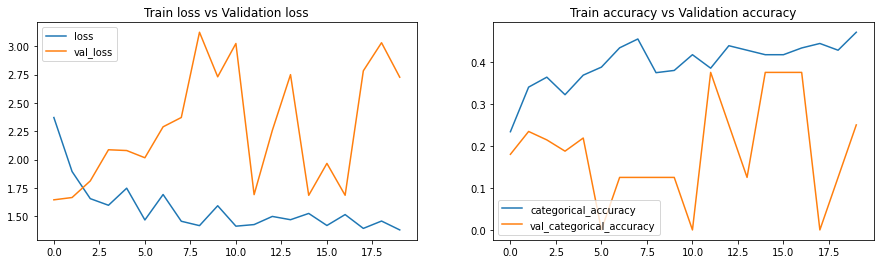

Max. Training Accuracy:  0.47058823704719543
Max. Validaiton Accuracy:  0.375


In [ ]:
plot_performance(history)

This time the model doesn't overfit that much but the training accuracy also goes below 50%.

### MODEL NUMBER 6: <br>
 
**FRAMES** = 16<br>
**EPOCHS** = 20<br>
**BATCH SIZE** = 64<br>
**3** CONV3D Layers<br> **2** DENSE Layers<br> **L2** Regularizer at Dense Layer<br>
**OPTIMIZER** = Adam<br>
**CHANGE DONE** - Reduced the number of CONV Layers and Dense Layers to make the model simple and more generic.

In [ ]:
# Initializing the frames, epochs and batch size
n_frames = 16
num_epochs = 20
batch_size = 64

img_tensor = get_image_tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Creating the model
model = Sequential()
model.add(Conv3D(32, (2,2,2), padding='same',input_shape=(len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(64, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(128, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64,activation='relu', kernel_regularizer=regularizers.l2(l2=0.0001)))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))

In [ ]:
# Compiling the model with Adam optimizer and getting the summary
model.compile(optimizer=RMSprop(lr=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 100, 100, 32)  800       
                                                                 
 activation_24 (Activation)  (None, 16, 100, 100, 32)  0         
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 8, 50, 50, 32)    0         
 g3D)                                                            
                                                                 
 batch_normalization_26 (Bat  (None, 8, 50, 50, 32)    128       
 chNormalization)                                                
                                                                 
 dropout_28 (Dropout)        (None, 8, 50, 50, 32)     0         
                                                                 
 conv3d_25 (Conv3D)          (None, 8, 50, 50, 64)    

In [ ]:
# Fitting the model
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - 169s 16s/step - loss: 1.9658 - categorical_accuracy: 0.3605 - val_loss: 1.7057 - val_categorical_accuracy: 0.1500 - lr: 1.0000e-04
Epoch 2/20
11/11 [==============================] - 75s 7s/step - loss: 1.3608 - categorical_accuracy: 0.4980 - val_loss: 2.1886 - val_categorical_accuracy: 0.2344 - lr: 1.0000e-04
Epoch 3/20
11/11 [==============================] - 70s 7s/step - loss: 1.3692 - categorical_accuracy: 0.4822 - val_loss: 2.6007 - val_categorical_accuracy: 0.2143 - lr: 1.0000e-04
Epoch 4/20
11/11 [==============================] - 58s 6s/step - loss: 1.2507 - categorical_accuracy: 0.5107 - val_loss: 3.1883 - val_categorical_accuracy: 0.1875 - lr: 1.0000e-04
Epoch 5/20
11/11 [==============================] - ETA: 0s - loss: 1.2563 - categorical_accuracy: 0.5072
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
11/11 [========================

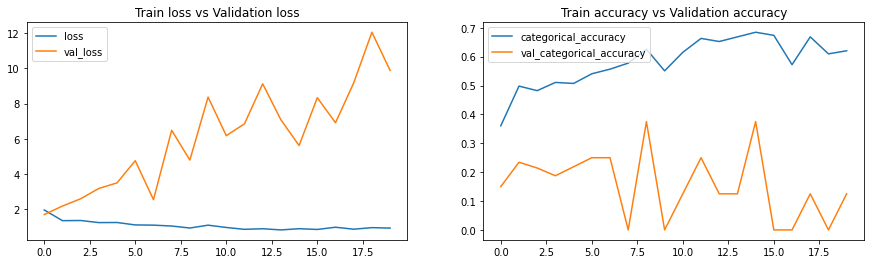

Max. Training Accuracy:  0.6844919919967651
Max. Validaiton Accuracy:  0.375


In [ ]:
plot_performance(history)

The model overfits yet again. 

### MODEL NUMBER 7: <br>
 
**FRAMES** = 16<br>
**EPOCHS** = 20<br>
**BATCH SIZE** = 64<br>
**ARCHIUTECTURE** = CNN + LSTM<br>
**5** CONV2D Layers<br>**1** LSTM Layer<br> **3** DENSE Layers<br> **L2** Regularizer at Dense Layer<br>
**OPTIMIZER** = Adam<br>
**CHANGE DONE** - Adding LSTM to CNN

In [ ]:
# Initializing the frames, epochs and batch size
n_frames = 16
num_epochs = 20
batch_size = 64

img_tensor = get_image_tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
  
input_shape=(len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

In [ ]:
# Creating the model
model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))


model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256))
model.add(Dropout(0.3))

model.add(Dense(256,activation='relu', kernel_regularizer=regularizers.l2(l2=0.0001)))
model.add(Dropout(0.3))

model.add(Dense(128,activation='relu', kernel_regularizer=regularizers.l2(l2=0.0001)))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))

In [ ]:
# Compiling the model with Adam optimizer and getting the summary
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeDi  (None, 16, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 16, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 16, 50, 50, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 16, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 16, 25, 25, 32) 

In [ ]:
# Fitting the model
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - 170s 16s/step - loss: 1.6499 - categorical_accuracy: 0.2805 - val_loss: 1.6504 - val_categorical_accuracy: 0.2600 - lr: 1.0000e-04
Epoch 2/20
11/11 [==============================] - 80s 8s/step - loss: 1.4545 - categorical_accuracy: 0.4150 - val_loss: 1.6601 - val_categorical_accuracy: 0.1562 - lr: 1.0000e-04
Epoch 3/20
11/11 [==============================] - 75s 7s/step - loss: 1.3496 - categorical_accuracy: 0.4901 - val_loss: 1.7105 - val_categorical_accuracy: 0.1964 - lr: 1.0000e-04
Epoch 4/20
11/11 [==============================] - 60s 6s/step - loss: 1.2960 - categorical_accuracy: 0.4936 - val_loss: 1.6863 - val_categorical_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 5/20
11/11 [==============================] - ETA: 0s - loss: 1.1252 - categorical_accuracy: 0.6124
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
11/11 [========================

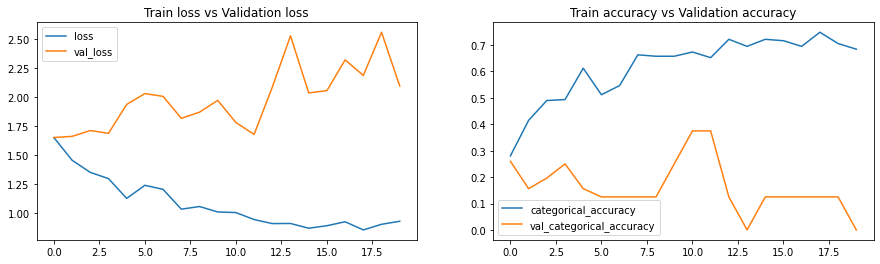

Max. Training Accuracy:  0.7486631274223328
Max. Validaiton Accuracy:  0.375


In [ ]:
plot_performance(history)

The model seems to be complex and the weights aren't getting updated as per the desired values.

### MODEL NUMBER 8: <br>
 
**FRAMES** = 16<br>
**EPOCHS** = 20<br>
**BATCH SIZE** = 64<br>
**ARCHIUTECTURE** = Transfer Learning Architecture to get prei-initialized weights
**1** LSTM Layer, **3** DENSE Layers, **L2** Regularizer at Dense Layer
**OPTIMIZER** = Adam<br>
**CHANGE DONE** - Adding LSTM to CNN<br>
**TRANSFER LEARNING** - MobileNet

In [ ]:
from tensorflow.keras.applications import mobilenet
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
# Initializing the frames, epochs and batch size
n_frames = 20
num_epochs = 25
batch_size = 64

img_tensor = get_image_tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Creating the model
model = Sequential()
model.add(TimeDistributed(mobilenet, input_shape=(len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])))

for layer in model.layers:
    layer.trainable = False
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(256))
model.add(Dropout(0.3))

model.add(Dense(256,activation='relu', kernel_regularizer=regularizers.l2(l2=0.0001)))
model.add(Dropout(0.3))

model.add(Dense(128,activation='relu', kernel_regularizer=regularizers.l2(l2=0.0001)))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))

In [ ]:
# Compiling the model with Adam optimizer and getting the summary
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_68 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_69 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_70 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_71 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_5 (LSTM)               (None, 256)             

In [ ]:
# Fitting the model
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 64
Epoch 1/25
11/11 [==============================] - 217s 21s/step - loss: 1.6749 - categorical_accuracy: 0.2323 - val_loss: 1.6234 - val_categorical_accuracy: 0.2800 - lr: 1.0000e-04
Epoch 2/25
11/11 [==============================] - 95s 10s/step - loss: 1.6500 - categorical_accuracy: 0.2411 - val_loss: 1.5766 - val_categorical_accuracy: 0.3906 - lr: 1.0000e-04
Epoch 3/25
11/11 [==============================] - 89s 9s/step - loss: 1.6039 - categorical_accuracy: 0.2767 - val_loss: 1.5336 - val_categorical_accuracy: 0.4286 - lr: 1.0000e-04
Epoch 4/25
11/11 [==============================] - 75s 7s/step - loss: 1.5656 - categorical_accuracy: 0.3305 - val_loss: 1.5413 - val_categorical_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 5/25
11/11 [==============================] - 71s 7s/step - loss: 1.5311 - categorical_accuracy: 0.3301 - val_loss: 1.4517 - val_categorical_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/25
11/11 [=============

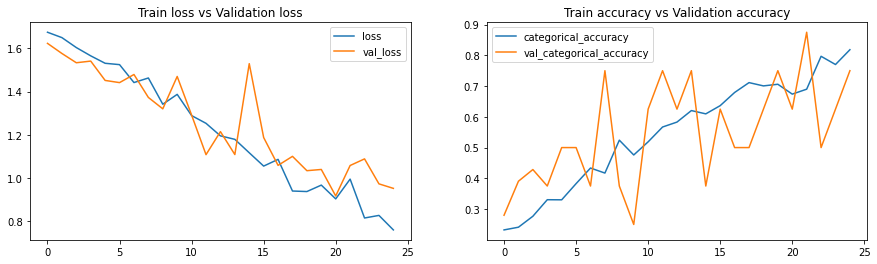

Max. Training Accuracy:  0.8181818127632141
Max. Validaiton Accuracy:  0.875


In [ ]:
plot_performance(history)

In [ ]:
# Saving the weights obtained.
model.save_weights('final_weights.h5')

We have achieved a much higher accuracy for the validation set. Maybe, if we fit the model for 50-75 epochs it will generate the result which generates an accuracy higher than this. So, using Transfer Learning with LSTM on top of it helped us in getting better results.